In [33]:
import librosa
import feature.extract as feature
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [34]:
SONG_FILE = "/Users/nurupo/Desktop/dev/audio/nogizaka46/乃木坂46 16th 「サヨナラの意味」 Best Shot Version..mp3"

# 1. Extracting acoustic features (chroma)

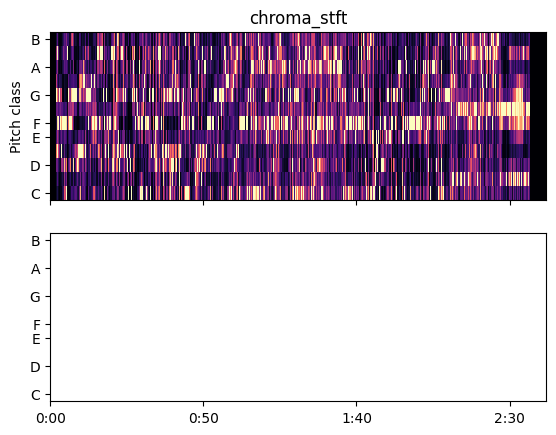

In [35]:
chroma = feature.extract_feature(SONG_FILE,"chroma_stft")
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='chroma_stft')
ax[0].label_outer()

# 2. Calculating the similarity

$$r(t, l) = 1 - \frac{\left|\frac{\mathbf{v}(t)}{\max_{c} v_c(t)} - \frac{\mathbf{v}(t-l)}{\max_{c} v_c(t-l)}\right|}{\sqrt{12}}$$
Where:

$r(t, l)$ : The similarity value between two chroma vectors
$t$ : The current time index
$l$ : The lag (time difference) between the two chroma vectors being compared
$\mathbf{v}(t)$ : The 12-dimensional chroma vector at time $t$
$\mathbf{v}(t-l)$ : The 12-dimensional chroma vector at time $t-l$
$v_c(t)$ : The $c$-th element of the chroma vector at time $t$ (where $c$ ranges from 1 to 12, representing the 12 pitch classes)
$\max_{c} v_c(t)$ : The maximum value among the 12 elements of the chroma vector at time $t$

In [65]:
def calculate_similarity(chroma):
    # Normalize chroma vectors
    chroma_norm = chroma / np.max(chroma, axis=0, keepdims=True)
    
    # Calculate similarity matrix
    similarity = 1 - np.sqrt(12) * np.abs(chroma_norm[:, :, np.newaxis] - chroma_norm[:, np.newaxis, :])
    similarity = np.mean(similarity, axis=0)
    
    # Normalize similarity
    similarity = (similarity - np.mean(similarity)) / np.std(similarity)
    
    # Remove noise (you may need to adjust the kernel size)
    kernel = np.ones((5, 5)) / 25
    similarity = convolve2d(similarity, kernel, mode='same', boundary='symm')
    
    return similarity

def calculate_r_all(similarity):
    t, _ = similarity.shape
    r_all = np.zeros_like(similarity)
    
    for l in range(t):
        r_all[:t-l, l] = np.mean(similarity[:t-l, l])
    
    return r_all


# Calculate similarity
similarity = calculate_similarity(chroma.T)

# Calculate R_all
r_all = calculate_r_all(similarity)

print(similarity.shape)
print(r_all.shape)
print(r_all)

(12, 12)
(12, 12)
[[ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
  -0.19510345 -0.36042047 -0.22888779 -0.07779535  0.14068852  0.06363335]
 [ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
  -0.19510345 -0.36042047 -0.22888779 -0.07779535  0.14068852  0.        ]
 [ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
  -0.19510345 -0.36042047 -0.22888779 -0.07779535  0.          0.        ]
 [ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
  -0.19510345 -0.36042047 -0.22888779  0.          0.          0.        ]
 [ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
  -0.19510345 -0.36042047  0.          0.          0.          0.        ]
 [ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
  -0.19510345  0.          0.          0.          0.          0.        ]
 [ 0.12946456  0.08109873  0.14088208 -0.00171279 -0.00399163 -0.12676102
   0.         

# 3. Listing the repeated sections

In [64]:
def list_repeated_sections(similarity, r_all, min_duration=2):
    frame_rate = 1 / 0.08  # Assuming 80ms per frame as in the paper
    min_frames = int(min_duration * frame_rate)
    
    # Normalize R_all to [0, 1] range
    r_all_norm = (r_all - np.min(r_all)) / (np.max(r_all) - np.min(r_all))
    # Smooth R_all
    r_all_smooth = gaussian_filter1d(r_all_norm, sigma=1, axis=0)
    
    # Find peaks in R_all with relaxed parameters
    peaks = []
    for i in range(r_all_smooth.shape[1]):
        row_peaks, _ = find_peaks(r_all_smooth[:, i], distance=min_frames, prominence=0.1, height=0.5)
        for peak in row_peaks:
            peaks.append((peak, i))
    
    # If no peaks found, use local maxima
    if not peaks:
        for i in range(r_all_smooth.shape[1]):
            row_maxima = np.argsort(r_all_smooth[:, i])[-5:]  # Top 5 values
            for peak in row_maxima:
                if r_all_smooth[peak, i] > 0.5:  # Only consider high values
                    peaks.append((peak, i))
    
    # Sort peaks by R_all value
    peaks.sort(key=lambda x: r_all_smooth[x], reverse=True)
    
    def find_line_segments(row, threshold):
        above_threshold = row > threshold
        diff = np.diff(np.pad(above_threshold, (1, 1), 'constant', constant_values=False))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        return list(zip(starts, ends))
    
    # Find line segments
    repeated_sections = []
    for peak in peaks:
        t, l = peak
        row = similarity[t, :]
        
        # Adaptive thresholding with relaxed criteria
        threshold = np.mean(row) + 0.5 * np.std(row)
        segments = find_line_segments(row, threshold)
        
        for start, end in segments:
            if end - start >= min_frames:
                repeated_sections.append({
                    'start': start,
                    'end': end,
                    'lag': l,
                    'r_value': r_all_smooth[t, l]
                })
    
    # Sort repeated sections by r_value
    repeated_sections.sort(key=lambda x: x['r_value'], reverse=True)
    
    return repeated_sections

# Usage
similarity = calculate_similarity(chroma.T)
r_all = calculate_r_all(similarity)
repeated_sections = list_repeated_sections(similarity, r_all)
print(repeated_sections)
# Print results
for i, section in enumerate(repeated_sections[:10]):  # Print top 10 sections
    print(f"Section {i+1}:")
    print(f"  Start: {section['start'] * 0.08:.2f}s")
    print(f"  End: {section['end'] * 0.08:.2f}s")
    print(f"  Duration: {(section['end'] - section['start']) * 0.08:.2f}s")
    print(f"  Lag: {section['lag'] * 0.08:.2f}s")
    print(f"  R-value: {section['r_value']:.4f}")
    print()

[]


Similarity shape: (12, 12)
R_all shape: (12, 12)


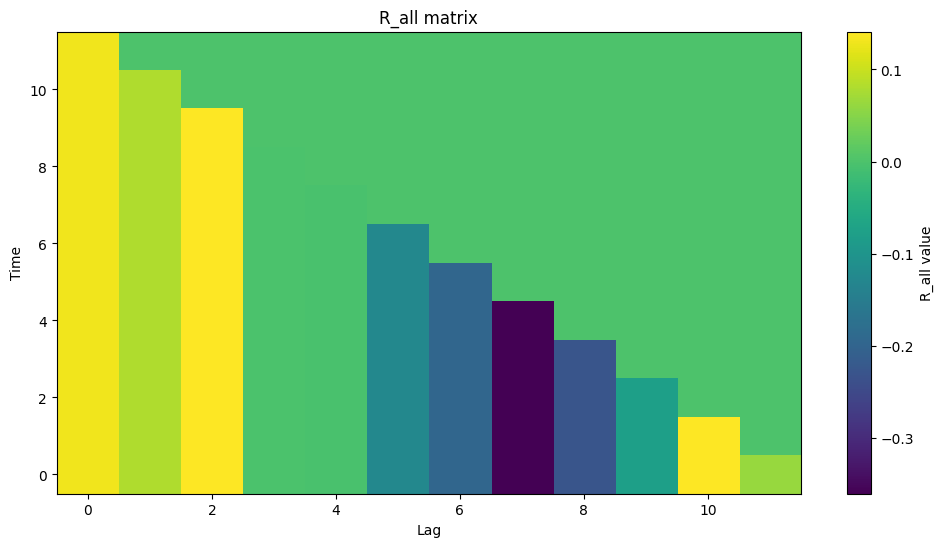

Total peaks found in R_all: 0
Average threshold value: 0.3118
Total segments found: 5


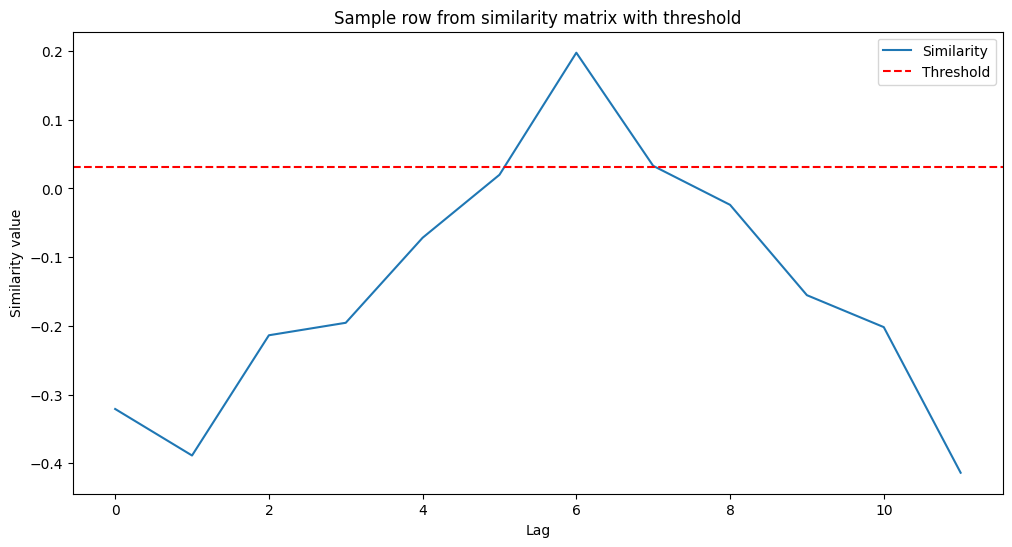

Minimum duration: 2 seconds (25 frames)


In [58]:
# Debug
def debug_list_repeated_sections(similarity, r_all, min_duration=2):
    frame_rate = 1 / 0.08  # Assuming 80ms per frame as in the paper
    min_frames = int(min_duration * frame_rate)
    
    # 1. Check input shapes
    print(f"Similarity shape: {similarity.shape}")
    print(f"R_all shape: {r_all.shape}")
    
    # 2. Visualize R_all
    plt.figure(figsize=(12, 6))
    plt.imshow(r_all, aspect='auto', origin='lower')
    plt.colorbar(label='R_all value')
    plt.title('R_all matrix')
    plt.xlabel('Lag')
    plt.ylabel('Time')
    plt.show()
    
    # 3. Smooth R_all and check for peaks
    r_all_smooth = gaussian_filter1d(r_all, sigma=3, axis=0)
    peaks_found = 0
    for i in range(r_all_smooth.shape[1]):
        row_peaks, _ = find_peaks(r_all_smooth[:, i], distance=min_frames)
        peaks_found += len(row_peaks)
    print(f"Total peaks found in R_all: {peaks_found}")
    
    # 4. Check thresholding
    threshold_values = []
    segments_found = 0
    for t in range(similarity.shape[0]):
        row = similarity[t, :]
        threshold = np.mean(row) + np.std(row)
        threshold_values.append(threshold)
        above_threshold = row > threshold
        segments = np.where(np.diff(above_threshold.astype(int)))[0]
        segments_found += len(segments) // 2
    
    print(f"Average threshold value: {np.mean(threshold_values):.4f}")
    print(f"Total segments found: {segments_found}")
    
    # 5. Visualize thresholding for a sample row
    sample_row = similarity[similarity.shape[0] // 2, :]
    threshold = np.mean(sample_row) + np.std(sample_row)
    
    plt.figure(figsize=(12, 6))
    plt.plot(sample_row, label='Similarity')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Sample row from similarity matrix with threshold')
    plt.xlabel('Lag')
    plt.ylabel('Similarity value')
    plt.legend()
    plt.show()
    
    # 6. Check minimum duration filter
    print(f"Minimum duration: {min_duration} seconds ({min_frames} frames)")
    
    return peaks_found, segments_found

# Usage
peaks_found, segments_found = debug_list_repeated_sections(similarity, r_all)

# If still no sections found, try with lower minimum duration
if segments_found == 0:
    print("\nTrying with lower minimum duration...")
    peaks_found, segments_found = debug_list_repeated_sections(similarity, r_all, min_duration=2)

# 4. Integrating the repeated sections

# 5. Detecting the modulated repetition (Deal with tonal moduation)